# How to Create an ARIMA Model for Time Series Forecasting with Python

[Tutorial](http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import datetime
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

%matplotlib inline

In [2]:
from pandas.plotting import autocorrelation_plot #fix this

In [3]:
series = pd.read_csv('../input/shampoo-sales.csv')

In [4]:
series.head()

,Month,Sales of shampoo over a three year period
0,01-Jan,266.0
1,01-Feb,145.9
2,01-Mar,183.1
3,01-Apr,119.3
4,01-May,180.3


In [5]:
def parser(x):
    return datetime.strptime('19'+x, '%Y-%b') #fix this

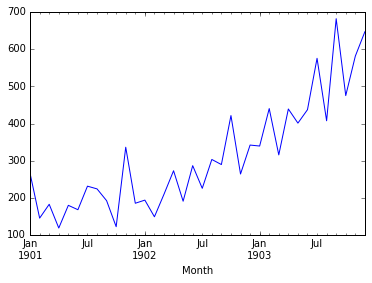

In [6]:
series = pd.read_csv('../input/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.plot()
plt.show()

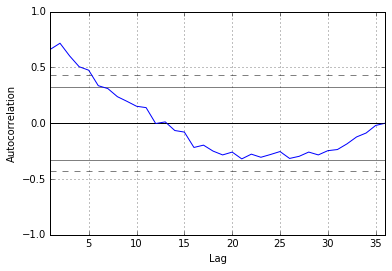

In [7]:
autocorrelation_plot(series)
plt.show()

 There is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags. A good starting point for the AR parameter of the model may be 5.

## ARIMA

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from pandas.core import datetools

/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
model = ARIMA(series, order=(5,1,0)) #p,d,q: parameters for AR, difference, MA
model_fit = model.fit(disp=0)

In [10]:
print(model_fit.summary())

                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Wed, 31 May 2017   AIC                            406.340
Time:                                                 21:38:03   BIC                            417.227
Sample:                                             02-01-1901   HQIC                           410.098
                                                  - 12-01-1903                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

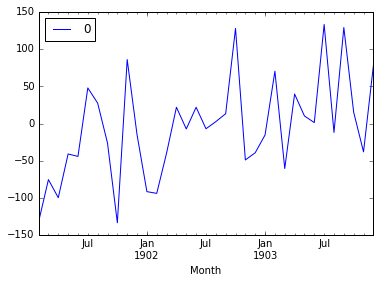

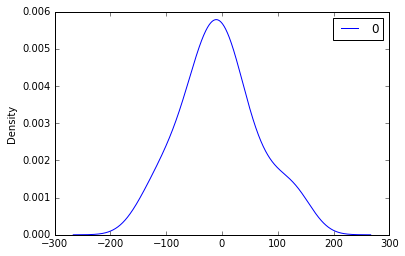

                0
count   35.000000
mean    -5.495257
std     68.132879
min   -133.296643
25%    -42.477920
50%     -7.186718
75%     24.748268
max    133.237914


In [11]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Rolling Forecast ARIMA Model

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [14]:
X = series.values
size = int(len(X) * 0.66)

In [16]:
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [17]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) #add predicted value to history used for next fit
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=349.117623, expected=342.300000
predicted=306.512934, expected=339.700000
predicted=387.376338, expected=440.400000
predicted=348.154217, expected=315.900000
predicted=386.308823, expected=439.300000
predicted=356.082070, expected=401.300000
predicted=446.379499, expected=437.400000
predicted=394.737282, expected=575.500000
predicted=434.915533, expected=407.600000
predicted=507.923404, expected=682.000000
predicted=435.483044, expected=475.300000
predicted=652.743857, expected=581.300000
predicted=546.343413, expected=646.900000


In [18]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 6958.328


In [21]:
error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)

Test MAE: 63.573


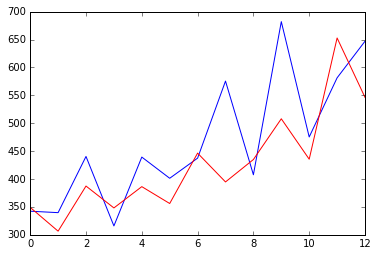

In [20]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# How to Save an ARIMA Time Series Forecasting Model in Python

[Tutorial](http://machinelearningmastery.com/save-arima-time-series-forecasting-model-python/)

In [24]:
from statsmodels.tsa.arima_model import ARIMAResults

In [22]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

In [25]:
# save model
model_fit.save('model.pkl')
# load model
loaded = ARIMAResults.load('model.pkl')

# How to Make Manual Predictions for ARIMA Models with Python

[Tutorial](http://machinelearningmastery.com/make-manual-predictions-arima-models-python/)

In [46]:
from pandas import Series
import matplotlib.pyplot as plt
from math import sqrt

In [38]:
# open with text and delete ?
series = Series.from_csv('../input/daily-minimum-temperatures.csv', header=0)

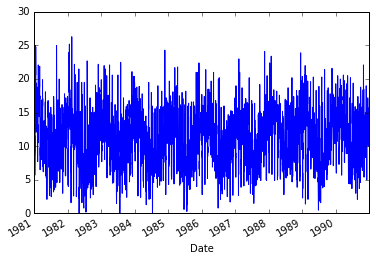

In [37]:
series.plot()
plt.show()

A walk-forward validation, or rolling forecast, method is used as follows:

1. Each time step in the test dataset is iterated.
2. Within each iteration, a new ARIMA model is trained on all available historical data.
3. The model is used to make a prediction for the next day.
4. The prediction is stored and the “real” observation is retrieved from the test set and added to the history for use in the next iteration.
5. The performance of the model is summarized at the end by calculating the root mean squared error (RMSE) of all predictions made compared to expected values in the test dataset.


The coefficients in the statsmodels implementation of the ARIMA model do not use intercept terms. This means we can calculate the output values by taking the dot product of the learned coefficients and lag values (in the case of an AR model) and lag residuals (in the case of an MA model). For example:

```y = dot_product(ar_coefficients, lags) + dot_product(ma_coefficients, residuals)```

**Note**: It is similar in R

The coefficients of a learned ARIMA model can be accessed from aARIMAResults object as follows:

- ```model_fit.arparams```

- ```model_fit.maparams```

In [39]:
# manual predict() function
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat

## AR

In [41]:
# lag k: AR(k)
k = 1
model = ARIMA(history, order=(k,0,0))

In [42]:
X = series.values
size = len(X) - 7
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()

In [43]:
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0)) # call model
    model_fit = model.fit(trend='nc', disp=False) #fit model
    ar_coef = model_fit.arparams  #coef of AR
    yhat = predict(ar_coef, history) #dot product
    predictions.append(yhat) #append result
    obs = test[t] 
    history.append(obs) # add predicted value to history
    print('>predicted=%.3f, expected=%.3f' % (yhat, obs))

>predicted=9.738, expected=12.900
>predicted=12.563, expected=14.600
>predicted=14.219, expected=14.000
>predicted=13.635, expected=13.600
>predicted=13.245, expected=13.500
>predicted=13.148, expected=15.700
>predicted=15.292, expected=13.000


In [48]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.928


## MA

In [49]:
# lag k
k = 1
model = ARIMA(history, order=(0,0,k))

In [50]:
X = series.values
size = len(X) - 7 #test on last 7 days
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()

In [51]:
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=False)
    ma_coef = model_fit.maparams
    # The residual errors during training are stored in the ARIMA model under the ‘resid‘ parameter of the ARIMAResults object.
    resid = model_fit.resid
    yhat = predict(ma_coef, resid)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('>predicted=%.3f, expected=%.3f' % (yhat, obs))

>predicted=4.610, expected=12.900
>predicted=7.085, expected=14.600
>predicted=6.423, expected=14.000
>predicted=6.476, expected=13.600
>predicted=6.089, expected=13.500
>predicted=6.335, expected=15.700
>predicted=8.006, expected=13.000


In [52]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.568


## ARMA

In [53]:
X = series.values
size = len(X) - 7
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()

In [54]:
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1)) # no differencing
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('>predicted=%.3f, expected=%.3f' % (yhat, obs))

>predicted=11.920, expected=12.900
>predicted=12.309, expected=14.600
>predicted=13.293, expected=14.000
>predicted=13.549, expected=13.600
>predicted=13.504, expected=13.500
>predicted=13.434, expected=15.700
>predicted=14.401, expected=13.000


In [55]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.405


## ARIMA

In [59]:
import numpy

In [60]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

In [61]:
X = series.values
size = len(X) - 7
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()

In [62]:
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
    resid = model_fit.resid
    diff = difference(history)
    yhat = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('>predicted=%.3f, expected=%.3f' % (yhat, obs))

>predicted=11.837, expected=12.900
>predicted=13.265, expected=14.600
>predicted=14.159, expected=14.000
>predicted=13.868, expected=13.600
>predicted=13.662, expected=13.500
>predicted=13.603, expected=15.700
>predicted=14.788, expected=13.000


In [63]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.232


# Sensitivity Analysis of History Size to Forecast Skill with ARIMA in Python

[Tutorial](http://machinelearningmastery.com/sensitivity-analysis-history-size-forecast-skill-arima-python/)

# How to Tune ARIMA Parameters in Python

[Tutorial](http://machinelearningmastery.com/tune-arima-parameters-python/)

# How to Grid Search ARIMA Model Hyperparameters with Python

[Tutorial](http://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)